In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# Unfortunately this URL doesn't work directly with pd.read_csv
# !wget -nc https://lazyprogrammer.me/course_files/spam.csv

In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns to something better
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [11]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [12]:
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [13]:
# 0 = padding
idx = 1
word2idx = {'<PAD>': 0}

In [14]:
# you could always use gensim or spacy for tokenization,
# but let's keep it simple!
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split() # simple tokenization
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [15]:
word2idx

{'<PAD>': 0,
 'prepare': 1,
 'to': 2,
 'be': 3,
 'pleasured': 4,
 ':)': 5,
 'ok.': 6,
 'i.ll': 7,
 'do': 8,
 'you': 9,
 'right': 10,
 'later.': 11,
 'honeybee': 12,
 'said:': 13,
 "*i'm": 14,
 'd': 15,
 'sweetest': 16,
 'in': 17,
 'world*': 18,
 'god': 19,
 'laughed': 20,
 '&amp;': 21,
 '*wait,u': 22,
 'havnt': 23,
 'met': 24,
 'person': 25,
 'reading': 26,
 'this': 27,
 'msg*': 28,
 'moral:': 29,
 'even': 30,
 'can': 31,
 'crack': 32,
 'jokes!': 33,
 'gm+gn+ge+gn:)': 34,
 'want': 35,
 '750': 36,
 'anytime': 37,
 'any': 38,
 'network': 39,
 'mins': 40,
 '150': 41,
 'text': 42,
 'and': 43,
 'a': 44,
 'new': 45,
 'video': 46,
 'phone': 47,
 'for': 48,
 'only': 49,
 'five': 50,
 'pounds': 51,
 'per': 52,
 'week': 53,
 'call': 54,
 '08000776320': 55,
 'now': 56,
 'or': 57,
 'reply': 58,
 'delivery': 59,
 'tomorrow': 60,
 'k...k:)why': 61,
 'cant': 62,
 'come': 63,
 'here': 64,
 'search': 65,
 'job:)': 66,
 'indians': 67,
 'r': 68,
 'poor': 69,
 'but': 70,
 'india': 71,
 'is': 72,
 'not': 7

In [16]:
len(word2idx)

10569

In [17]:
# convert data into word indices
# note: could have done this on the fly earlier
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [18]:
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [19]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

In [20]:
def data_generator(X, y, batch_size=32):
  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y) / batch_size))
  for i in range(n_batches):
    end = min((i + 1) * batch_size, len(y))

    X_batch = X[i * batch_size:end]
    y_batch = y[i * batch_size:end]

    # pad X_batch to be N x T
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x
    
    # convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()
    
    yield X_batch, y_batch

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
# What is the shape of embedding output?
# N x T x D
embed = nn.Embedding(len(word2idx), 20)
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  out = embed(inputs)
  print("Input shape:", inputs.shape) # N x T
  print("Output shape:", out.shape)   # N x T x D
  break

Input shape: torch.Size([32, 41])
Output shape: torch.Size([32, 41, 20])


In [23]:
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # if input is T words
    # then output is (T, D) matrix
    self.embed = nn.Embedding(self.V, self.D)        

    # conv 1D layers & pool 1D layers
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1) 
    self.pool1 = nn.MaxPool1d(2)                     
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)     
    self.pool2 = nn.MaxPool1d(2)                     
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)    
    
    self.fc = nn.Linear(128, self.K)                 
  
  def forward(self, X):                        # input is (N, T)
    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)                        # output is (N, T, D)

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    out = out.permute(0, 2, 1)                 # output is (N, D, T)
    out = self.conv1(out)                      # output is (N, M, T)
    out = F.relu(out)
    out = self.pool1(out)                      # output is (N, M, T2)
    out = self.conv2(out)                      # output is (N, M2, T2)
    out = F.relu(out)
    out = self.pool2(out)                      # output is (N, M2, T3)
    out = self.conv3(out)                      # output is (N, M3, T3)
    out = F.relu(out)

    # change it back
    out = out.permute(0, 2, 1)                 # output is (N, T3, M3)

    # max pool
    out, _ = torch.max(out, 1)                 # output is (N, M3)

    # final dense layer
    out = self.fc(out)                         # output is (N, K)
    return out

In [24]:
model = CNN(len(word2idx), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10569, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [25]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [26]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [27]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_gen():
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      # print("outputs.shape:", outputs.shape)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_gen():
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [28]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 8)

Epoch 1/8, Train Loss: 0.4064,       Test Loss: 0.3600, Duration: 0:00:01.009042
Epoch 2/8, Train Loss: 0.2909,       Test Loss: 0.2498, Duration: 0:00:01.220799
Epoch 3/8, Train Loss: 0.1774,       Test Loss: 0.1638, Duration: 0:00:00.913854
Epoch 4/8, Train Loss: 0.1044,       Test Loss: 0.1450, Duration: 0:00:00.892588
Epoch 5/8, Train Loss: 0.0737,       Test Loss: 0.1668, Duration: 0:00:00.847106
Epoch 6/8, Train Loss: 0.0502,       Test Loss: 0.1351, Duration: 0:00:00.906038
Epoch 7/8, Train Loss: 0.0417,       Test Loss: 0.1417, Duration: 0:00:00.933015
Epoch 8/8, Train Loss: 0.0264,       Test Loss: 0.1959, Duration: 0:00:00.930228


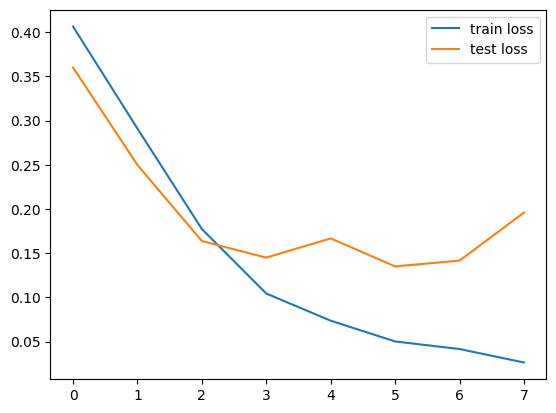

In [29]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [30]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9906, Test acc: 0.9554
